In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#from tensorflow.keras import layers
#from tensorflow.keras import regularizers
import keras_tuner as kt

from sklearn.metrics import mean_absolute_error, mean_squared_error
#from sklearn.preprocessing import OneHotEncoder


tf.__version__

2023-04-19 13:54:41.115231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 13:54:41.198171: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-19 13:54:41.597853: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-19 13:54:41.597890: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [2]:
# Load dataset
csv_file = '../Dataset/dataset.csv'
#csv_file = '../Dataset/dataset_left.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,2,484.4822,350.23
1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,2,774.6917,347.50
2,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,4,644.6140,364.11
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,2,630.3364,347.10
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,4,392.8587,358.78


In [3]:
dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,484.4822
1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,774.6917
2,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,644.6140
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,630.3364
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,392.8587


1
32
140
40
40


Text(0, 0.5, 'count')

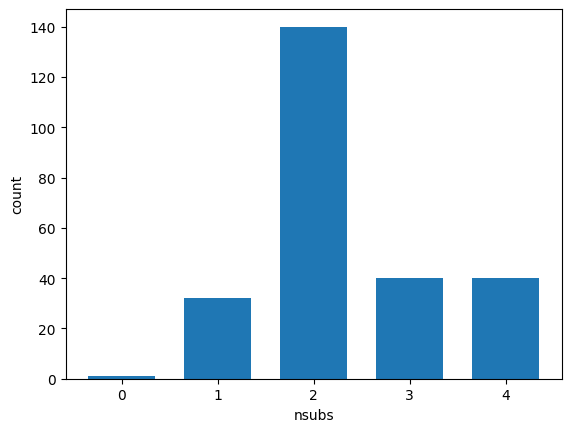

In [4]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)
plt.xlabel('nsubs')
plt.ylabel('count')

In [5]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,253.0,0.343874,0.923853,0.0000,0.0000,0.0000,0.0000,4.0000
Pos2,253.0,0.403162,1.040599,0.0000,0.0000,0.0000,0.0000,4.0000
Pos3,253.0,0.363636,0.989118,0.0000,0.0000,0.0000,0.0000,4.0000
Pos4,253.0,0.422925,1.034613,0.0000,0.0000,0.0000,0.0000,4.0000
Pos5,253.0,0.399209,1.013167,0.0000,0.0000,0.0000,0.0000,4.0000
Pos6,253.0,0.304348,0.889902,0.0000,0.0000,0.0000,0.0000,4.0000
Pos7,253.0,0.316206,0.892436,0.0000,0.0000,0.0000,0.0000,4.0000
Pos8,253.0,0.367589,0.957042,0.0000,0.0000,0.0000,0.0000,4.0000
Pos9,253.0,0.498024,1.125549,0.0000,0.0000,0.0000,0.0000,4.0000
Pos10,253.0,0.351779,0.987404,0.0000,0.0000,0.0000,0.0000,4.0000


/tmp/ipykernel_20094/2418938743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe[['target']])


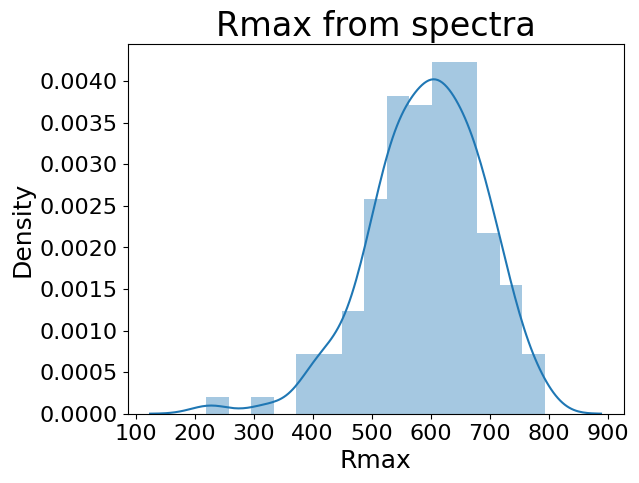

In [6]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

#sns.pairplot(dataframe[['target']], diag_kind='kde')
#sns.set_style('darkgrid')
sns.distplot(dataframe[['target']])
plt.title('Rmax from spectra',fontsize=24)
plt.xlabel('Rmax',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Text(0, 0.5, 'Rmax')

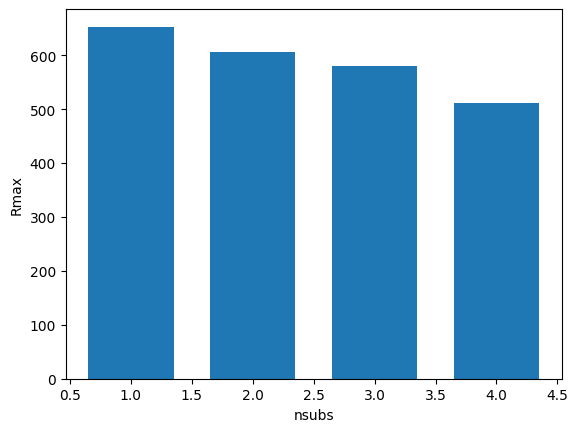

In [7]:
# Rmax as a function of nsubs
Rmax = []
Rmax[:] = dataframe['target']

nsubs1 = [i for i in range(len(nsubs)) if nsubs[i]==1]
nsubs2 = [i for i in range(len(nsubs)) if nsubs[i]==2]
nsubs3 = [i for i in range(len(nsubs)) if nsubs[i]==3]
nsubs4 = [i for i in range(len(nsubs)) if nsubs[i]==4]

Rmax1 = [Rmax[i] for i in nsubs1]
Rmax2 = [Rmax[i] for i in nsubs2]
Rmax3 = [Rmax[i] for i in nsubs3]
Rmax4 = [Rmax[i] for i in nsubs4]

Rmax1_mean = np.mean(Rmax1)
Rmax2_mean = np.mean(Rmax2)
Rmax3_mean = np.mean(Rmax3)
Rmax4_mean = np.mean(Rmax4)

Rmax_mean = [Rmax1_mean, Rmax2_mean, Rmax3_mean, Rmax4_mean]

bin_edges = np.arange(1.5,4.5+1,1)
plt.bar([1,2,3,4],Rmax_mean, width=0.7)
plt.xlabel('nsubs')
plt.ylabel('Rmax')


In [8]:
# remove data with R~8

dataframe = dataframe[ dataframe['target']>10 ]
dataframe.describe().transpose()

# remove data with target<Rmin
Rmin = 380
dataframe = dataframe[ dataframe['target']>Rmin ]
print(dataframe.describe().transpose())

        count        mean        std       min      25%       50%       75%  \
Pos1    249.0    0.337349   0.923839    0.0000    0.000    0.0000    0.0000   
Pos2    249.0    0.373494   0.996496    0.0000    0.000    0.0000    0.0000   
Pos3    249.0    0.333333   0.948967    0.0000    0.000    0.0000    0.0000   
Pos4    249.0    0.413655   1.016782    0.0000    0.000    0.0000    0.0000   
Pos5    249.0    0.405622   1.020026    0.0000    0.000    0.0000    0.0000   
Pos6    249.0    0.309237   0.896203    0.0000    0.000    0.0000    0.0000   
Pos7    249.0    0.321285   0.898693    0.0000    0.000    0.0000    0.0000   
Pos8    249.0    0.373494   0.963581    0.0000    0.000    0.0000    0.0000   
Pos9    249.0    0.506024   1.132797    0.0000    0.000    0.0000    0.0000   
Pos10   249.0    0.357430   0.994316    0.0000    0.000    0.0000    0.0000   
Pos11   249.0    0.341365   0.946095    0.0000    0.000    0.0000    0.0000   
Pos12   249.0    0.353414   0.969078    0.0000    0.

In [9]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,249.0,3.373494e-01,0.923839,0.000000,0.000000,0.000000,0.000000,4.000000
Pos2,249.0,3.734940e-01,0.996496,0.000000,0.000000,0.000000,0.000000,4.000000
Pos3,249.0,3.333333e-01,0.948967,0.000000,0.000000,0.000000,0.000000,4.000000
Pos4,249.0,4.136546e-01,1.016782,0.000000,0.000000,0.000000,0.000000,4.000000
Pos5,249.0,4.056225e-01,1.020026,0.000000,0.000000,0.000000,0.000000,4.000000
Pos6,249.0,3.092369e-01,0.896203,0.000000,0.000000,0.000000,0.000000,4.000000
Pos7,249.0,3.212851e-01,0.898693,0.000000,0.000000,0.000000,0.000000,4.000000
Pos8,249.0,3.734940e-01,0.963581,0.000000,0.000000,0.000000,0.000000,4.000000
Pos9,249.0,5.060241e-01,1.132797,0.000000,0.000000,0.000000,0.000000,4.000000
Pos10,249.0,3.574297e-01,0.994316,0.000000,0.000000,0.000000,0.000000,4.000000


In [10]:
# One-hot encode inpute features manually 
n_data = dataset.shape[0]
n_atom_types = 5   # (H,Fl,Cl,Br,I)
n_pos = 16         # 6-helicenes have 16 possible positions to be occupied
n_features = int(n_atom_types*n_pos)
x_data = np.zeros( (n_data, n_features) )
y_data = np.zeros(n_data)

n_labels = 1
data = np.zeros( (n_data, n_features+n_labels) )

dataset_np = dataset.to_numpy()
#print(dataset_np.shape)
for i in range(n_data):
    for j in range(n_pos):
        atom_id = int(dataset_np[i,j])
        x_data[i,j*n_atom_types+atom_id] = 1.0

    #print(x_data[i,:])
    #print(dataset_np[i,:16])

    y_data[i] = dataset_np[i,n_pos]

    data[i,0:n_features] = x_data[i,:] 
    data[i,n_features] = y_data[i]

print(x_data.shape)
print(y_data.shape)
print(data.shape)


(249, 80)
(249,)
(249, 81)


In [11]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#x_data = data[:,0:n_features]
#y_data = data[:,n_features]
data = shuffle(data, random_state=39)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

print(len(x_train), 'training examples')
print(len(x_test), 'test and validation examples')
print(x_train.shape)
print(y_train.shape)

199 training examples
50 test and validation examples
(199, 80)
(199,)


In [12]:
# non-linear model with multiple inputs

# First, define a single model for a single position
def single_model():
    inputs = tf.keras.Input( shape=(n_atom_types,) )
    x = tf.keras.layers.Dense(8,activation='relu')(inputs)
    #outputs = tf.keras.layers.Dense(1)(x)
    outputs = tf.keras.layers.Dense(8,activation='relu')(x)
    return tf.keras.Model(inputs,outputs)

# save into a list 8 models
linear_models = []
for i in range(int(n_pos/2)):
    model_i = single_model()
    linear_models.append(model_i)

# save into a list inputs for different positions
inputs = []
for i in range(n_pos):
    input_i = tf.keras.Input( shape=(n_atom_types,), name='Pos_'+str(i+1) )
    inputs.append( input_i ) 
    #input_i = tf.keras.Input(shape=(n_atom_types,name="Pos_i"))
    #input_i = tf.keras.Input( shape=(n_atom_types,), name='Pos_i' )
print(inputs)

linear_outputs = []
# save into a list linear outputs for positions 1-8
for i in range(int(n_pos/2)):
    output_i = linear_models[i]( inputs[i] )
    linear_outputs.append( output_i )

# save into a list linear outputs for positions 9-16
for i in range(int(n_pos/2),n_pos):
    output_i = linear_models[n_pos-1-i]( inputs[i] )
    linear_outputs.append( output_i )    

print(linear_outputs)

#global_output = tf.keras.layers.Add(name='SUM')(linear_outputs)
x = tf.keras.layers.Concatenate()(linear_outputs)
x = tf.keras.layers.Dense(32,activation='relu')(x)
global_output = tf.keras.layers.Dense(1)(x)
print(global_output)

model = tf.keras.Model(inputs=inputs,outputs=global_output)
model.summary()
tf.keras.utils.plot_model(model, "non-linear_many-body_invariant_model.png", show_shapes=True)

learning_rate = 0.01
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error')

[<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_1')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_2')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_3')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_4')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_5')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_6')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_7')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_8')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_9')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_10')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_11')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_12')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_13')>, <KerasTensor: shape=(None, 5) dtype=float32 (c

2023-04-19 13:59:21.520325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-19 13:59:21.542171: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-04-19 13:59:21.542194: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-19 13:59:21.542684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

In [13]:
# Train the model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-6)

epochs = 200
batch_size = 4

# split input into 16 positions
train_inputs = np.split(x_train,n_pos,axis=1)
print(len(train_inputs))
#history = model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)
history = model.fit(x=train_inputs, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)

16
Epoch 1/200
45/45 - 2s - loss: 0.8515 - val_loss: 0.6231 - lr: 0.0100 - 2s/epoch - 36ms/step
Epoch 2/200
45/45 - 0s - loss: 0.7350 - val_loss: 0.3670 - lr: 0.0100 - 70ms/epoch - 2ms/step
Epoch 3/200
45/45 - 0s - loss: 0.5079 - val_loss: 0.4971 - lr: 0.0100 - 74ms/epoch - 2ms/step
Epoch 4/200
45/45 - 0s - loss: 0.4743 - val_loss: 0.3811 - lr: 0.0100 - 76ms/epoch - 2ms/step
Epoch 5/200
45/45 - 0s - loss: 0.3891 - val_loss: 0.3037 - lr: 0.0100 - 76ms/epoch - 2ms/step
Epoch 6/200
45/45 - 0s - loss: 0.4249 - val_loss: 0.3539 - lr: 0.0100 - 75ms/epoch - 2ms/step
Epoch 7/200
45/45 - 0s - loss: 0.3585 - val_loss: 0.3579 - lr: 0.0100 - 75ms/epoch - 2ms/step
Epoch 8/200
45/45 - 0s - loss: 0.3359 - val_loss: 0.3195 - lr: 0.0100 - 78ms/epoch - 2ms/step
Epoch 9/200
45/45 - 0s - loss: 0.3063 - val_loss: 0.3162 - lr: 0.0100 - 77ms/epoch - 2ms/step
Epoch 10/200
45/45 - 0s - loss: 0.3148 - val_loss: 0.3071 - lr: 0.0100 - 82ms/epoch - 2ms/step
Epoch 11/200
45/45 - 0s - loss: 0.2945 - val_loss: 0.3377

Best epoch: 35


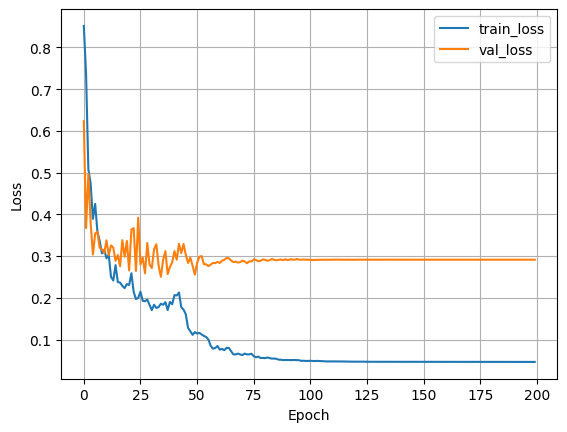

In [14]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [15]:
def plot_PredvsTrue(y_true, y_pred):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

2/2 [==============================] - 0s 3ms/step
(50, 1)
(50, 1)


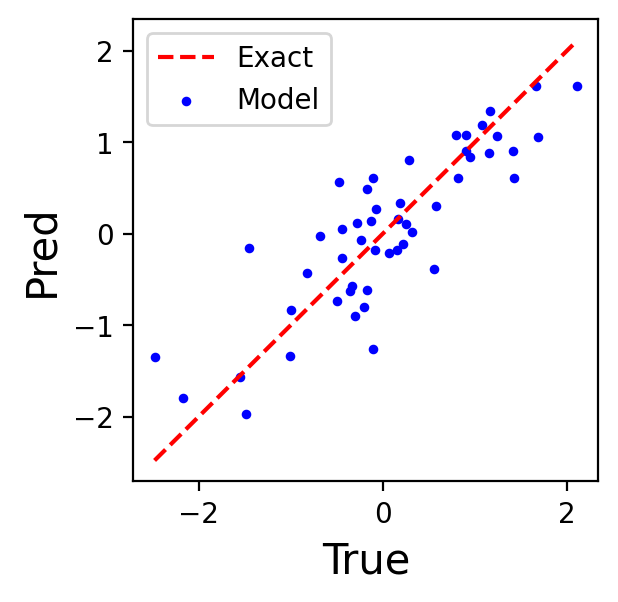

Test MAE: 0.4007893754374717


In [16]:
# Pred vs True values on test set 

#y_pred = model.predict(x_test)
test_inputs = np.split(x_test,n_pos,axis=1)
y_pred = model.predict(test_inputs)
y_pred.shape
y_true = np.zeros((len(y_test),1))
y_true[:,0] = y_test[:]

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Test MAE: "+str(test_mae))

In [17]:
# save model

#reloaded_model = tf.keras.models.load_model('R_model')
model.save('./Models/R_model_invariant_non-linear_many-body')

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_non-linear_many-body/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_non-linear_many-body/assets


7/7 [==============================] - 0s 1ms/step


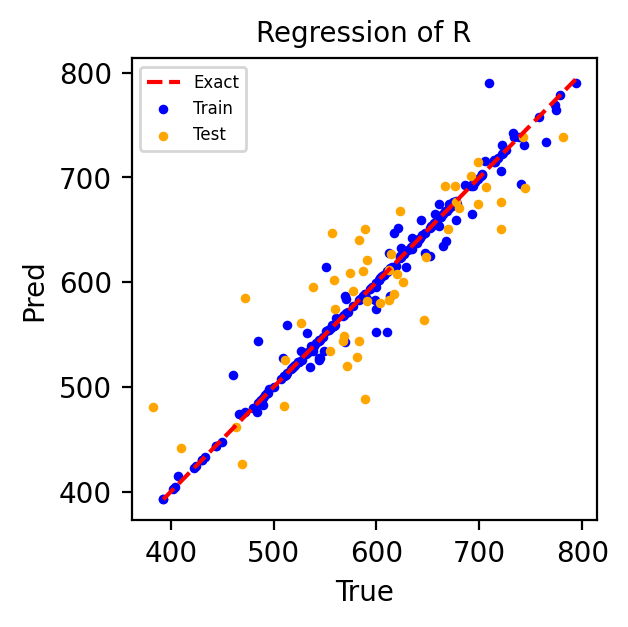

train MAE (non-normalized): 6.167265949621154
test MAE (non-normalized): 34.87019470800781


In [18]:
# Evaluate the model with non-normalized units on the whole dataset

#y_pred_test = model.predict(x_test)
y_pred_test = model.predict(test_inputs)
y_true_test = np.zeros((len(y_test),1))
y_true_test[:,0] = y_test[:]

#y_pred_train = model.predict(x_train)
y_pred_train = model.predict(train_inputs)
y_true_train = np.zeros((len(y_train),1))
y_true_train[:,0] = y_train[:]

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

#y_true_val = y_true_val * R_std + R_mean
#y_pred_val = y_pred_val * R_std + R_mean
#y_true_val = y_true_val.ravel()
#y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
#plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("train MAE (non-normalized): "+str(train_mae))
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("test MAE (non-normalized): "+str(test_mae))
#val_mae = mean_absolute_error(y_true_val,y_pred_val)
#print("val MAE (non-normalized): "+str(val_mae))

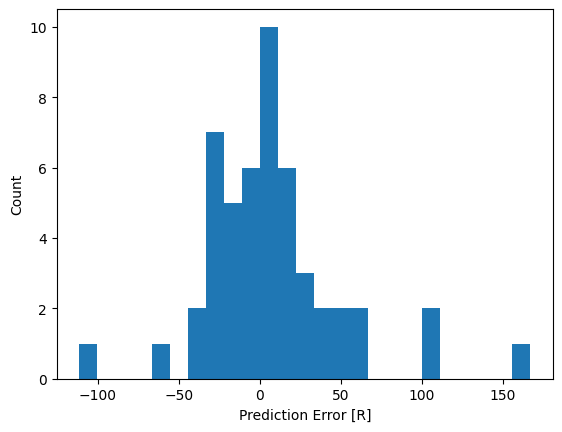

In [21]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')


[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0.]
[2. 2. 2. 0. 2. 2. 4. 2. 3. 2. 2. 3. 2. 2. 2. 2. 3. 1. 4. 2. 4. 2. 1. 2.
 2. 4. 2. 4. 2. 3. 2. 2. 2. 2. 2. 1. 2. 4. 4. 2. 3. 4. 3. 1. 2. 2. 3. 3.
 1. 1.]
[ 1.  6. 27.  8.  8.]
[ 0.98625703 12.21684471 24.72854932 32.76378101 60.15458557]


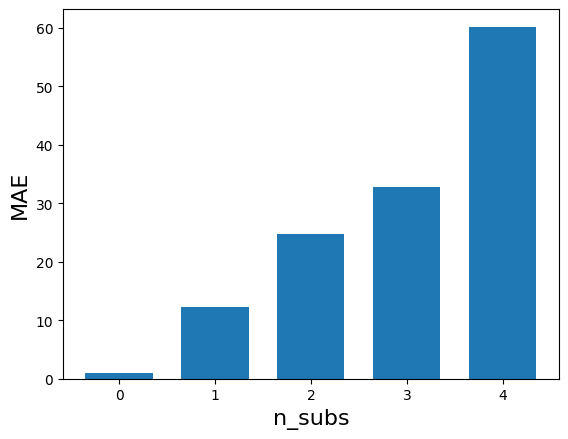

In [22]:
# Error for different nsubs

#x_test = test_features.to_numpy()

nsubs_test = np.zeros( x_test.shape[0] )
print(x_test[0,:])

# compute number of substitutes for each data test
for i in range(len(nsubs_test)):

    # for each data, check if first input of every position is an hydrogen
    nsubs_i = 0
    for j in range(n_pos):
        if( x_test[i,j*n_atom_types]==0.0 ): # no hydrogen, hence there is a different substitute
            nsubs_i = nsubs_i+1
    nsubs_test[i] = nsubs_i
print(nsubs_test)

error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
num_subs = np.zeros(5)
for i in range(len(nsubs_test)):
    error_i = y_pred_test[i] - y_true_test[i]
    if(nsubs_test[i]==0): 
        error0.append(error_i)
        num_subs[0] +=1
    if(nsubs_test[i]==1): 
        error1.append(error_i)
        num_subs[1] +=1
    if(nsubs_test[i]==2): 
        error2.append(error_i)
        num_subs[2] +=1
    if(nsubs_test[i]==3): 
        error3.append(error_i)
        num_subs[3] +=1
    if(nsubs_test[i]==4): 
        error4.append(error_i)
        num_subs[4] +=1

error_nsubs = np.zeros(5)
error_nsubs[0] = np.mean(np.abs(error0))
error_nsubs[1] = np.mean(np.abs(error1))
error_nsubs[2] = np.mean(np.abs(error2))
error_nsubs[3] = np.mean(np.abs(error3))
error_nsubs[4] = np.mean(np.abs(error4))

print(num_subs)
print(error_nsubs)

bin_edges = np.arange(1.5,4.5+1,1)
plt.bar([0,1,2,3,4],error_nsubs[0:], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.show()